## Overview

When applying the IMOCO pipeline, one challenge has been objectively assessing the processed lung MRI images. The original metrics provided by the IMOCO paper did not fully align with our visual observations. In particular, the previously recommended parameters (e.g., certain lambda values) often led to results that appeared overly smooth, contradicting what the original metrics suggested was optimal.

To address this discrepancy, we aim to explore additional, more automated image quality assessment metrics that better correlate with our visual impressions. Specifically, we will examine image sharpness and noise characteristics. The idea is to identify a complementary set of metrics that can guide us in selecting parameters without requiring extensive manual inspection or masking.

Our approach focuses on three key areas:

1. **Image Sharpness:**  
   We need metrics that ensure the processed images preserve important anatomical details rather than becoming overly smooth. Two well-established indicators are:  
   - **Laplacian Variance:** Measures how much the image deviates from a smooth, flat surface. Higher variance indicates sharper features.  
   - **Gradient Magnitude:** Quantifies the strength of intensity transitions in the image, reflecting edge clarity.

2. **Noise Metrics:**  
   While sharpness metrics help prevent over-smoothing, we must also consider the noise level and signal quality. We will use:  
   - **Entropy:** Captures the complexity and intensity distribution of the image. Excessive noise or irregularities can inflate entropy values.  
   - **Standard Deviation (in a uniform region):** Provides a direct measure of intensity variability. High noise leads to increased variability.

3. **Combining Metrics:**  
   By comparing images across these metrics, we hope to identify parameter sets that produce both visually and quantitatively superior results. Our goal is to find a set of parameters that yield sharp, detailed images with acceptable noise levels—ideally matching what a human observer would consider “good” quality.

In the sections that follow, we will implement these metrics, evaluate different parameter sets, and compare the numerical results to our visual assessments. This process will help us pinpoint which metrics or combinations thereof are most predictive of image quality in lung MRI post-processing.

### 1 - Image Sharpness

#### **Laplacian Variance**
- **Reference:** [PyImageSearch Blog Post](https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/)
  
#### **Methodology**  
The Laplacian Variance method leverages the Laplacian operator, which is the second derivative of an image. The Laplacian highlights regions with rapid intensity changes, such as edges and fine details.  

The steps are as follows:  
1. Extract a single grayscale channel of the image.  
2. Convolve the image with a **3x3 Laplacian kernel**, which enhances edge-like regions by capturing areas where intensity changes occur abruptly.  
3. Compute the **variance** of the Laplacian-filtered image.  

#### **Intuition**  
- The Laplacian operator emphasizes edges and regions with high spatial frequency in the image.  
- **High variance** of the Laplacian response indicates a wide spread of pixel values, suggesting that the image contains both edge-like and non-edge-like regions. This is typically indicative of a sharp, in-focus image.  
- **Low variance** corresponds to a narrow spread of values, meaning that very few edges or details are present. This is usually the result of excessive smoothing or blurring, where fine anatomical structures are lost.  

#### **Why It Works**  
The variance of the Laplacian acts as a quantitative measure of image sharpness:  
- Sharp, well-focused images have a **high Laplacian variance** due to the presence of many well-defined edges.  
- Overly smoothed or blurred images exhibit a **low Laplacian variance** because intensity transitions are suppressed, leading to fewer discernible edges.  


In [28]:
# utils.py 
import cv2
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_slice(volume, x=None, y=None, z=None):
    if x is not None:
        slice_2d = volume[x, :, :]
        title = f'Slice at X={x}'
    elif y is not None:
        slice_2d = volume[:, y, :]
        title = f'Slice at Y={y}'
    elif z is not None:
        slice_2d = volume[:, :, z]
        title = f'Slice at Z={z}'
    else:
        raise ValueError("One of x, y, or z must be specified")
    
    plt.imshow(slice_2d, cmap='gray')
    plt.title(title)
    plt.show()
    return 

def load_dicom_series(dicom_dir):
    dicom_files = sorted([os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.DCM')])
    slices = [pydicom.dcmread(dcm) for dcm in dicom_files]
    slices.sort(key=lambda x: int(x.InstanceNumber)) 
    volume = np.stack([s.pixel_array for s in slices], axis=-1)
    return volume

In [32]:
def variance_of_laplacian(slice):
    # computes the variance of laplacian 
    laplacian = cv2.Laplacian(slice, cv2.CV_64F)
    return laplacian.var()

def dcm_var_of_lap(dicom_vol):
    variance_lst = []
    # get variance for each slice 
    for slice in range(dicom_vol.shape[0]):
        slice_2d = dicom_vol[slice , : , : ]
        var_lap = variance_of_laplacian(slice_2d)
        variance_lst.append(var_lap)
    
    return variance_lst

In [36]:
base_folder = '/Users/akshdeepsandhu/Desktop/imoco_lammy_testing/imrh_0110b/'
lammy_variances = {}

for folder_name in sorted(os.listdir(base_folder)):
    if folder_name.startswith('imoco_dcm_'):
        folder_path = os.path.join(base_folder,folder_name)
        dicom_vol  = load_dicom_series(folder_path)
        variance_dcm = dcm_var_of_lap(dicom_vol)
        lammy_variances[folder_name] = variance_dcm

variance_df = pd.DataFrame(lammy_variances)
variance_df.head()

,imoco_dcm_0,imoco_dcm_0.01,imoco_dcm_0.02,imoco_dcm_0.03,imoco_dcm_0.04,imoco_dcm_0.05
0,3822.599630,1335.464397,389.590174,167.203247,171.989404,182.933821
1,3015.549559,1162.276597,369.747770,132.241917,119.917643,142.428298
2,2891.994482,1147.868130,378.262957,133.317938,111.020613,131.645845
3,2861.632490,1140.256306,373.176253,126.967042,105.098297,126.106362
4,2976.365314,1180.355430,382.394933,126.133124,103.767752,127.922220


count      255.000000
mean     14165.594561
std      14480.404958
min       2746.291369
25%       3768.725858
50%       9827.855044
75%      14987.796420
max      60122.952184
dtype: float64


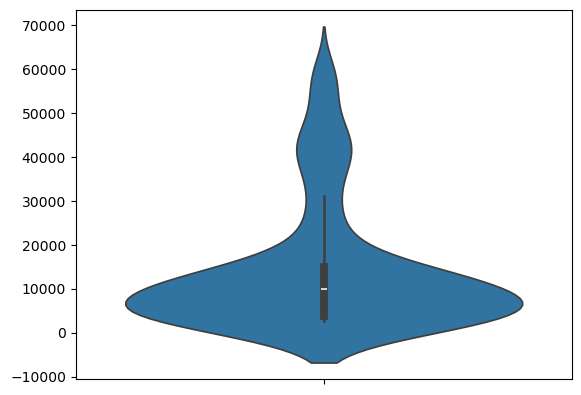

In [ ]:
test_path = '/Users/akshdeepsandhu/Desktop/imoco_lammy_testing/imrh_0110b/imoco_dcm_0'
dicom_vol = load_dicom_series(test_path)
variance_dcm = dcm_var_of_lap(dicom_vol)

sns.violinplot(variance_dcm)
print(pd.Series(variance_dcm).describe())